Esta práctica consiste en detectar de ciertas zonas de interés en coches. Está compuesta por tres apartados y en
cada uno se deberá desarrollar un fichero. La práctica deberá ejecutarse sobre Python 3.7.X y OpenCV 4.2. y  los
ficheros serán los siguientes:

- deteccion_orb.py
- detección_haar.py
- deteccion_video.py

Para ejecutar la práctica deberá escribirse en la consola de comandos `python` seguido del nombre del fichero sin ningún
otro parámetro adicional. Se supondrá que los directorios test, train y haar y los videos están en el mismo directorio
que los ficheros python. Al ejecutar estos ficheros python se mostrará por pantalla el resultado sobre cada una de las
imágenes o vídeos de test.

# Detección de coches mediante puntos de interés

Este apartado aparece desarrollado en el fichero *deteccion_orb.py*.

Inicialmente se importan las librerías necesarias para la ejecución del programa y se comprueba que las versiones de
Python y OpenCV son las correctas. Se debe usar la versión 3.7 de Python y la versión 4.2 de OpenCV.

In [1]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
import sys
import math

assert (sys.version.startswith('3.7')), "No se esta usando la version 3.7 de Python. Version en uso: " + sys.version
assert (cv2.__version__.startswith('4.2')), "No se esta usando la version 4.2 de OpenCV. Version en uso: " + cv2.__version__

Si se están usando las versiones adecuadas, no se mostrará nada por pantalla. En otro caso, se mostrará un mensaje de
error indicando la versión que se está usando y la que se debe usar.

*sys* permite comprobar la versión de Python, _os_ será útil a la hora de cargar las imágenes de un directorio,
*cv2* se usará para cargar y procesar las imágenes, _pyplot_ permite mostrar las imágenes, *numpy* es útil para
manipular las matrices correspondientes a las imágenes y *math* se usará para realizar operaciones aritméticas y
trigonométricas.

A continuación, se definen algunos métodos para la carga de imágenes.

El método `load()` recibe una cadena de texto como parámetro que indica el nombre del directorio en el que se encuentran
las imágenes a cargar. El directorio por defecto es _train_, ya que este método se usará siempre que se quiera entrenar
el sistema y contiene las imágenes de entrenamiento. Se obtiene la ruta en la que se encuentra el fichero
actual con `os.path.abspath(os.curdir)` y concatena la cadena de texto pasada como parámetro para obtener la ruta
completa del directorio de entrenamiento. A continuación, lista los ficheros
que se encuentran en el directorio mediante el método `os.listdir()`. Este método devuelve una lista de cadenas de texto
con los nombres de los archivos que se encuentran en el directorio en un orden aleatorio. Para mantener el orden de las 
imágenes se llama al método `ordenar()`. Por último, se carga cada una de estas imágenes mediante el método
`cv2.imread()`, que recibe la ruta de cada imagen del directorio y el flag 0, que indica que la imagen se carga en
niveles de gris; y se devuelve una lista de matrices con todas las imágenes del directorio.

El método `load_color()` carga las imágenes igual que el método anterior, pero manteniendo el color de las imágenes. La
diferencia es que en el momento de la carga no se emplea el flag 0.

El método `ordenar()` recibe una lista de cadenas de texto y las devuelve ordenadas.
El método `sort()` para listas de Python ordena la lista del siguiente modo:

>['frontal_1.jpg', 'frontal_10.jpg', 'frontal_11.jpg', ... , 'frontal_19.jpg', 'frontal_2.jpg', 'frontal_20.jpg', ...,]

Pero sería más adecuado mantener las imágenes en un orden natural (0, 1, 2, 3,...). Para ello, primero se ordenan las
cadenas por longitud, de modo que las imágenes de los frontales del 1 al 10 quedarían al principio. Se obtienen
estas cadenas de texto y se ordenan, se ordena el resto por separado y, por último, se concatenan y se devuelven.

In [2]:
def ordenar(lst):
    lst.sort(key=len)
    ret = lst[0:10]
    ret.sort()
    aux = lst[10:]
    aux.sort()
    return ret + aux


def load(directory='train'):
    cur_dir = os.path.abspath(os.curdir)
    files = ordenar(os.listdir(cur_dir + '/' + directory))
    return [cv2.imread(directory + '/' + file, 0) for file in files]


def load_color(directory):
    cur_dir = os.path.abspath(os.curdir)
    files = ordenar(os.listdir(cur_dir + '/' + directory))
    return [cv2.imread(directory + '/' + file) for file in files]

También hay un método `soft_load()` que carga solamente 6 imágenes preseleccionadas aleatoriamente del directorio _train_.

In [3]:
def soft_load():
    return [cv2.imread('train/frontal_9.jpg', 0), cv2.imread('train/frontal_39.jpg', 0),
            cv2.imread('train/frontal_43.jpg', 0), cv2.imread('train/frontal_7.jpg', 0),
            cv2.imread('train/frontal_19.jpg', 0), cv2.imread('train/frontal_26.jpg', 0)]

Inicialmente se implementó otro método `load2()` para cargar las imágenes. Este método concatena una cadena de texto
que contiene una parte común de la ruta de todas las imágenes de test con un número del 1 al 49. De este modo, es
posible cargar las 48 imágenes de test, pero si se añaden más imágenes al directorio, estas no se cargarán.
En cambio, el método
`load()` sí lo haría. Por este motivo y porque ambos métodos tienen un tiempo de ejecución similar se decidió usar el
método `load()`.

In [4]:
def load2():
    return [cv2.imread('train/frontal_' + str(i) + '.jpg', 0) for i in range(1, 49)]


A continuación, se implementan unos métodos `calculate_module()` y `calculate_angle_to_centre()` que serán necesarios más
adelante para calcular el módulo del vector que une un punto con el centro de las imágenes de entrenamiento y el ángulo
en grados que forma dicho vector respecto a la porción positiva del eje X en sentido horario, respectivamente. Ambos
métodos reciben una tupla con las coordenadas del punto como parámetro. Pueden recibir un segundo punto para construir
el vector. Si no lo reciben, se calcula el vector con un punto preestablecido, considerado el centro del frontal.

El primer método calcula el módulo mediante la raíz cuadrada (`np.sqrt()`) de la suma de las diferencias de las
coordenadas de los puntos elevadas al cuadrado. En el segundo método, la función `math.atan2()` recibe las longitudes
de los catetos y devuelve el ángulo del vector en radianes. El signo de las longitudes determinará qué porción de los
ejes se toma como referencia. El siguiente dibujo explica cómo se deben realizar los cálculos.

El ángulo
en radianes se multiplica por 180 y se divide por *pi* para tenerlo en grados y, por último, se obtiene el
módulo de 360 para que no se pase de una vuelta.

In [5]:
def calculate_module(p, centre=(225, 110)):
    return np.sqrt((centre[0] - p[0]) ** 2 + (centre[1] - p[1]) ** 2)


def calculate_angle_to_centre(p, centre=(225, 110)):
    return (math.atan2((p[1] - centre[1]), (centre[0] - p[0])) * 180 / math.pi) % 360

También se crea una clase _Match_ para almacenar los puntos de interés aprendidos durante el entrenamiento con su
correspondiente vector de votación. En esta
clase se almacena el módulo del vector que une el punto de interés con el centro de la imagen, el ángulo que forma este
vector como se ha indicado antes, la escala del punto de interés y el ángulo del punto de interés respecto de la imagen.

In [6]:
class Match:
    def __init__(self, module, kp_angle, scale, des_angle):
        self.module = module
        self.kp_angle = kp_angle
        self.scale = scale
        self.des_angle = des_angle

    def get_module(self):
        return self.module

    def get_kp_angle(self):
        return self.kp_angle

    def get_scale(self):
        return self.scale

    def get_des_angle(self):
        return self.des_angle

En un primer momento, el entrenamiento y la detección se realizaban dentro de un mismo método. Más tarde se observó que
sería necesario utilizar estas operaciones en otros apartados, por lo que se decidió desacoplar el entrenamiento de la
detección, implementándolos en métodos distintos.

El método `train()` corresponde al entrenamiento del sistema. Este método recibe una lista de imágenes y un detector de
puntos de interés y descriptores y devuelve una tabla de objetos *Match* con los puntos de interés aprendidos y una
estructura de datos de tipo flann entrenada con los descriptores de las imágenes de entrenamiento. En el método se crea
una estructura de datos tipo *FlannBasedMatcher* que sirve como árbol de búsqueda. En el constructor se indica que el 
algoritmo de búsqueda sea _LSH_ y que se busque en todas las hojas del árbol. Se inicializa la tabla de puntos de 
interés aprendidos *match_table* y se recorre la lista de imágenes recibida. Para cada imagen se obtienen los puntos
de interés (_kps_) y descriptores (*des*).

A continuación, para cada punto de interés, se almacenan en una lista auxiliar
*image_match* los objetos _Match_ con la información necesaria para la detección. El flann es capaz de encontrar los
descriptores más parecidos, pero además, hay que "enseñar" dónde está el centro de la imagen y para ello está la tabla
*match_table*. Por cada punto de interés encontrado, se debe guardar un vector que apunte hacia el centro del frontal,
el denominado vector de votación.
Por ejemplo, si se encuentra el faro derecho del coche, el vector deberá apuntar a la izquierda, ya que ahí se
encontraría el centro del frontal. De este modo, cuando se encuentre un faro derecho en una imagen de test, la tabla
indicará que el centro está a la izquierda porque ya lo ha aprendido. Ya que las imágenes están centradas y cuadradas
en el frontal de los coches de entrenaniento, se asumirá que los centros de los frontales corresponden a los centros de
las imágenes. Todas las imágenes tienen el mismo tamaño y, por tanto, un centro común. Es por este motivo que las
funciones `calculate_module()` y `calculate_angle_to_centre()` calculan los vectores respecto a dicho centro común, el
punto (225,110).

La lista auxiliar se introduce en la
tabla y se añade una lista con los descriptores de la imagen al *flann* mediante el método `add()`. Es importante
destacar que se deben añadir los descriptores de la imagen dentro de una lista, debido a que cada vez que se llama al
método `add()`, la lista pasada como parámetro se concatena con una lista con los descriptores ya aprendidos. Para que la
búsqueda funcione correctamente y se devuelvan las distancias entre descriptores e índices correctos, se deben
separar los descriptores de las distintas imágenes.

In [7]:
def train(images, detector):
    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=3, multi_probe_level=1)
    search_params = dict(checks=-1)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    match_table = []
    for image in images:
        kps, des = detector.detectAndCompute(image, None)
        image_match = [Match(calculate_module(k.pt), calculate_angle_to_centre(k.pt), k.size, k.angle) for k in kps]
        match_table.append(image_match)
        flann.add([des])

    return match_table, flann

El método `detect()` corresponde a la fase de detección en las imágenes de test. Recibe como
parámetros una lista con las imágenes test, un detector de puntos de interés y descriptores, la tabla con los puntos de 
interés aprendidos y los vectores de votación, el flann entrenado, el
número de emparejamientos a devolver y la sigma del kernel gaussiano; y devuelve una lista de tuplas con las coordenadas
de los centros de los frontales de cada imagen de test. Adicionalmente, recibe un parámetro *debug*. Si este parámetro
vale 1 se crearán listas para almacenar los descriptores, puntos de interés y matrices de votación de cada imagen de
test para facilitar la depuración.

Primero se define una lista *detected_points* que almacenará los puntos a devolver. A continuación, se
recorre la lista de imágenes recibida y para cada imagen se obtienen los puntos de interés y los descriptores. Se
realiza una llamada a la función `knnMatch()`, que busca los $k$ descriptores más cercanos a los de la imagen de test.
La cercanía o distancia entre descriptores no es la distancia que separa a los puntos de interés, sino la distancia de
Hamming entre los descriptores, que se traduce en la similitud entre los códigos binarios de estos.
La función devuelve los índices de la imágen de entrenamiento en la que se ha encontrado el emparejaminto
(_imgIdx_), del descriptor de dicha imagen con el cual se ha emparejado (_trainIdx_) y del descriptor de testing
emparejado (_queryIdx_). Una vez se tienen los emparejamientos, se recorren obteniendo los índices mencionados
anteriomente. Es importante tener en cuenta que los descriptores de las imágenes están directamente relacionados con
los puntos de interés a través de los índices. Esto significa que si los puntos de interés se han almacenado en orden
correctamente según se cargaban, los índices obtenidos servirán para localizar los vectores de votación de los
puntos de interés aprendidos
correspondientes a los descriptores emparejados y que estaban almacenados en la tabla *match_table*.

Al localizar el
punto de interés de entrenamiento se obtiene el objeto _Match_, el cual contiene el módulo y el ángulo del vector que,
partiendo de las coordenadas del punto de interés, emite el voto. Sin
embargo, se debe tener en cuenta la relación entre las escalas y los ángulos de los puntos de interés emparejados.
La diferencia
entre las escalas modificará el módulo del vector para adaptarlo a la imagen de test y una simple operación aritmética
devolverá el ángulo final del vector. Multiplicando el coseno del ángulo por el nuevo módulo y sumándo el resultado a la
coordenada x del punto de interés de la imagen test se obtiene la coordenada x del punto en el que se encontraría el
frontal. La matriz de votación se ha creado con una resolución 10 veces menor, que aunque aumenta la incertidumbre,
permite la acumulación de votos, por lo que se debe dividir el resultado entre 10.
Se calcula el punto de la otra coordenada operando esta vez
con el seno y se añade 1 voto a la matriz de votación controlando que no se salga de los límites. El coseno
y el seno calculados tienen tales signos para calcular los ángulos respecto a la porción positiva del eje x.

Al terminar el bucle se dispondrá de una matriz con una celda (o varias) con valor máximo que indicará la
posición del frontal. Es posible que la matriz tenga dos zonas (o más) de valores máximos o focos, ambos con el mismo valor
máximo, pero que uno de ellos tenga votos altos agrupados y el otro un único voto máximo. En estos casos es posible que
se escoja el punto que no corresponde al centro, y por ello hay que tener en cuenta no solo los valores máximos
puntuales sino la agrupación de valores altos, ya que estos últimos corresponderán al centro. Para ello, se
convoluciona la matriz con un kernel gausiano que permitirá localizar los focos más grandes. En la matriz suavizada se
aprecia cómo las celdas agrupadas aumentan su valor y destacan sobre las celdas solitarias.

Para obtener los índices de dicha celda se puede usar la función `unravel_index()` de Numpy. La tupla obtenida
se multiplica por 10 para volver a la resolución inicial de la imagen de test y se añade a la lista declarada
al inicio. Para finalizar, se devuelve la lista de tuplas con las coordenadas de los centros de los frontales de
las imágenes de test.

In [8]:
def detect(images, detector, match_table, flann, knn_matches, sigma, debug):
    if debug == 1:
        test_kps_table = []
        test_des_table = []
        matrices_votacion = []
    detected_points = []

    for test_image in images:
        kps, des = detector.detectAndCompute(test_image, None)
        if debug == 1:
            test_des_table.append(des)
            test_kps_table.append(kps)

        results = flann.knnMatch(des, k=knn_matches)

        matriz_votacion = np.zeros((int(test_image.shape[0] / 10), int(test_image.shape[1] / 10)), dtype=np.float32)

        for r in results:
            for m in r:
                match = match_table[m.imgIdx][m.trainIdx]
                m_test = kps[m.queryIdx]
                mod = (m_test.size / match.get_scale()) * match.get_module()
                angle = match.get_kp_angle() + match.get_des_angle() - m_test.angle
                x = int((m_test.pt[0] + (mod * math.cos(angle))) / 10)
                y = int((m_test.pt[1] - (mod * math.sin(angle))) / 10)
                if 0 < x < matriz_votacion.shape[1] and 0 < y < matriz_votacion.shape[0]:
                    matriz_votacion[y, x] += 1

        ksize = 6 * sigma + 1
        kernel_y = cv2.getGaussianKernel(ksize, sigma)
        kernel_x = kernel_y.T
        matriz_filtrada = cv2.sepFilter2D(matriz_votacion, -1, kernel_y, kernel_x)

        if debug == 1:
            matrices_votacion.append(matriz_filtrada)

        z = np.unravel_index(np.argmax(matriz_filtrada, axis=None), matriz_filtrada.shape)
        q = (int(z[1] * 10), int(z[0] * 10))
        detected_points.append(q)

    return detected_points

Después de la obtención de los emparejamientos en `results = flann.knnMatch(des, k=knn_matches)` es posible realizar un
filtrado de los emparejamientos obtenidos para obtener los mejores. El mejor criterio para la obtención de estos
emparejamientos es la distancia relativa, es decir, que se seleccionará un emparejamiento como mejor si la distancia es
menor que la distancia del siguiente emparejamiento respecto a un umbral relativo denominado _ratio test_. Lowe
comprobó experimentalmante que un buen valor de este umbral era 0,7 - 0,8. Se mantendría un emparejamiento $m_{1}$ si
se cumple que:

$distancia(m_{1}) < ratio$ $test$ $*$ $distancia(m_{2})$

, siendo $m_{2}$ el siguiente mejor emparejamiento.

Tras realizar este filtrado con los valores indicados, resultaba una lista vacía de emparejamientos, pues no había
tanta distancia relativa entre ellos. Era necesario un _ratio test_ de 0,95 para obtener emparejamientos, por lo que
se desechó este filtrado.

In [ ]:
good = []
    for r in results:
        aux = []
        for i in range(len(r)-1):
            m = r[i]
            n = r[i+1]
            if m.distance < 0.95 * n.distance:
                aux.append(m)
        good.append(aux)

Se ha decidido desacoplar la detección de la presentación de los resultados una vez más para permitir el uso
de estos métodos en otros apartados. El método `draw_points()` recibe una lista de tuplas con coordenadas de puntos y
una lista de imágenes sobre las que mostrar estos puntos. Se recorren ambas listas dibujando un círculo de color azul,
radio 15 y grosor 10 mediante la función `cv2.circle()` y mostrándo la imagen y un identificador con el número de
imagen en pantalla.

In [9]:
def draw_points(images, points):
    for index in range(len(images)):
        cv2.circle(images[index], points[index], 15, (255, 0, 0), thickness=10, lineType=8, shift=0)
        plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_RGB2BGR))
        plt.title("Imagen " + str(index + 1))
        plt.show()

Todos estos métodos se invocan en la función `main()`. Esta recibe unos parámetros que indican, respectivamente, el
número de puntos de interés a detectar en cada imagen, el factor de escala entre los distintos niveles, y los niveles,
de la pirámide del detector, el número de emparejamientos a obtener, la sigma del kernel gausiano y, por último, un
entero que facilita la depuración del programa.

Se comienza almacenando las imágenes de entrenamiento en *train_images* y creando un detector ORB mediante
`cv2.ORB_create()`. El detector creará una pirámide de imágenes a distinta escala de la cual obtendrá
los puntos de interés y los descriptores. La diferencia de escala entre cada imagen de la pirámide sera *scale_factor*
y el número de imágenes será *pyramid_levels*, y el número de descriptores devuelto será *num_keypoints*.
A continuación, se llama a la función de entrenamiento, que recibe los dos objetos
creados y devuelve un árbol de búsqueda flann entrenado y una tabla con los puntos de interés aprendidos y los
vectores de votación. El siguiente
paso es cargar las imágenes de test; se cargarán en niveles de gris en una lista, y en color en otra. A continuación,
se invoca la función de detección, que devolverá las
coordenadas en las que se encuentran los frontales de las imágenes de test. Para acabar, se muestra la localización de
los frontales llamando a la función `draw_points()`.

In [10]:
def main(num_keypoints, scale_factor, pyramid_levels, knn_matches, gaussian_kernel_sigma, debug=0):
    train_images = load()
    orb = cv2.ORB_create(nfeatures=num_keypoints, scaleFactor=scale_factor, nlevels=pyramid_levels)
    match_table, flann = train(train_images, orb)
    test_images = load('test')
    test_images_color = load_color('test')
    detected_points = detect(test_images, orb, match_table, flann, knn_matches, gaussian_kernel_sigma, debug)
    draw_points(test_images_color, detected_points)

Por último, se introduce una estructura de control para llamar a la función `main()` y ejecutar el código cuando se
ejecute el mandato `python deteccion_orb.py`. De este modo, también es posible importar el fichero en otro programa e
invocar los métodos definidos. Se han declarado unas constantes que representan todas las variables de las que depende
el programa.

In [11]:
if __name__ == "__main__":
    NUM_KEYPOINTS = 300
    SCALE_FACTOR = 1.3
    PYRAMID_LEVELS = 4
    KNN_MATCHES = 4
    GAUSSIAN_KERNEL_SIGMA = 2

    main(NUM_KEYPOINTS, SCALE_FACTOR, PYRAMID_LEVELS, KNN_MATCHES, GAUSSIAN_KERNEL_SIGMA)

Cuando se ejecute el fichero, aparecerán las imágenes de test con los frontales marcados de uno en uno. La imagen no
desaparecerá hasta que se cierre la ventana o se pulse la tecla *q*. En ese momento aparecerá la siguiente imagen.

## Estadísticas

Se ha comprobado la efectividad del programa variando *num_keypoints* y *knn_matches* y contando el número de
frontales detectado en cada caso.No se han presentado el resto de variables porque no influían tanto en la detección
como estas.

Para la primera variable se han tomado los valores almacenados en la lista _x_ y el porcentaje de frontales
detectados correctamente se ha almacenado en *y*.

Text(0, 0.5, 'Porcentaje de frontales detectados')

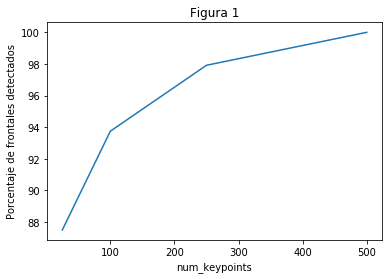

In [12]:
x = [25, 100, 250, 500]
y = [42/48*100, 45/48*100, 47/48*100, 48/48*100]

plt.plot(x,y)
plt.title("Figura 1")
plt.xlabel("num_keypoints")
plt.ylabel("Porcentaje de frontales detectados")

Se puede observar que esta variable influye mucho en la detección, ya que el porcentaje varía mucho al variar la
variable. Cuanto mayor es su número, mayor es el porcentaje de detección.

Al estudiar el porcentaje de detección respecto a *knn_matches* se han obtenido los siguientes resultados.

Text(0, 0.5, 'Porcentaje de frontales detectados')

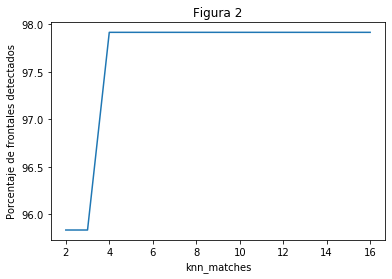

In [13]:
x = [2, 3, 4, 6, 10, 16]
y = [46/48*100, 46/48*100, 47/48*100, 47/48*100, 47/48*100, 47/48*100]


plt.plot(x,y)
plt.title("Figura 2")
plt.xlabel("knn_matches")
plt.ylabel("Porcentaje de frontales detectados")

En el caso de esta variable, se observa que no influye tanto en la detección puesto que aun con mucha
variación, el porcentaje de detección no cambia mucho.

Los valores que se han seleccionado finalmente son los presentes en el *main*.

# Detección de coches usando cv2.CascadeClassifier

Este apartado aparece desarrollado en el fichero *deteccion_haar.py*.

Al inicio del fichero se importan las librerías a utilizar. Cabe destacar que se importa el fichero desarollado en
el aparado anterior `import deteccion_orb as orbdet` para poder hacer uso del método `load()`.

Al igual que en el apartado anterior, se ha decidido hacer una aplicación modular para que los métodos definidos se
puedan usar en otros ficheros.

In [14]:
import cv2
from matplotlib import pyplot as plt
import deteccion_orb as orbdet

Para desarrollar este apartado se ha consultado la documentación de OpenCV. En ella aparecía un ejemplo de código con
un fin muy similar al de este apartado, por lo que se decidió tomar ese código y adaptarlo.

El método `detect()` corresponde a la fase de detección del frontal fnt y la matrícula de los coches. Recibe una lista de
imágenes en nivel de gris sobre las que detectar las zonas de interés, una lista con las mismas imágenes en color para
dibujar sobre ellas dichas zonas, clasificadores para coches y matrículas y dos valores numéricos a utilizar en
la detección. Se declara una lista con las imágenes a devolver y
se recorren las imágenes en gris detectando zonas de interés, en este caso frontales de coche, mediante el método
`detectMultiScale()`. Este método recibe como parámetros la imágen sobre la que detectar, el factor
de escala entre las imágenes generadas (similar a como hacía ORB con la pirámide) y el número mínimo de vecinos que
debe tener una zona candidata para ser válida. La función devuelve las coordenadas del rectángulo que representa la zona
en la que se encuentra el coche (los dos primeros enteros indican las coordenadas de la esquina superior
izquierda y los otros dos, la anchura y altura, respectivamente). La función `cv2.rectangle()`  recibe la imagen en
color y las esquinas superior izquierda e inferior derecha del rectángulo y lo dibuja con el color y grosor dados.
La detección de la mátrícula se podría hacer de dos
maneras: buscándola en la región delimitada por el coche (ya que la matrícula está en él) o en toda la imagen. Se ha
realizado la detección de ambas formas para ver el comportamiento del algoritmo. Almacenando la región en la que se
encuentra el coche en las variables _roi_ se busca la matrícula del mismo modo que antes y se dibuja un rectángulo
más grueso para diferenciar la detección de matrículas en el frontal de la detección en toda la imagen. Por último, se
busca la matrícula en toda la imágen. La imagen con todas las zonas detectadas se guarda en la lista a devolver.

In [15]:
def detect(gray_images, color_images, coches_cascade, matriculas_cascade, scale_factor, min_neighbors):
    detected_images = []

    for i in range(len(gray_images)):
        gray = gray_images[i]
        color = color_images[i]

        coche = coches_cascade.detectMultiScale(gray, scale_factor, min_neighbors)
        for (x, y, w, h) in coche:
            color = cv2.rectangle(color, (x, y), (x + w, y + h), (255, 0, 0), 2)
            roi_gray = gray[y:y + h, x:x + w]
            roi_color = color[y:y + h, x:x + w]
            matricula = matriculas_cascade.detectMultiScale(roi_gray, scale_factor, min_neighbors)
            for (ex, ey, ew, eh) in matricula:
                cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 4)

        matricula = matriculas_cascade.detectMultiScale(gray, scale_factor, min_neighbors)
        for (x, y, w, h) in matricula:
            color = cv2.rectangle(color, (x, y), (x + w, y + h), (0, 0, 255), 2)

        detected_images.append(color)

    return detected_images

El siguiente método simplemente recibe una lista de imágenes y las muestra por pantalla indicando su índice.
 La función `cv2.color()` recibe una imagen y la transformación de color a realizar sobre ella. Las imágenes en
OpenCV se cargan en BGR y lo más común es que se muestren en RGB, por lo que se cambia el orden de los canales y se
muestra.

In [16]:
def show(images):
    for i in range(len(images)):
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_RGB2BGR))
        plt.title("Imagen " + str(i + 1))
        plt.show()

En el directorio *haar_opencv_4.1-4.2* se incluyen los ficheros _coches.xml_ y _matriculas.xml_, que corresponden a
clasificadores entrenados para la detección de coches y matrículas, respectivamente. Para utilizar estos clasificadores
es necesario invocar la función `cv2.CascadeClassifier()`, que recibirá un fichero xml y devolverá el clasificador
entrenado. En la función principal se crean dos clasificadores, uno para coches y otro para matrículas. A
continuación, se cargan las imágenes en niveles de gris y en color y se llama a la función de detección. Esta
devolverá una lista de imágenes con las zonas de interés marcadas con un rectángulo. Para acabar se llama a la función
que muestra las imágenes por pantalla.

In [17]:
def main(scale_factor, min_neighbors):
    coches_cascade = cv2.CascadeClassifier('haar_opencv_4.1-4.2/coches.xml')
    matriculas_cascade = cv2.CascadeClassifier('haar_opencv_4.1-4.2/matriculas.xml')

    test_images_gray = orbdet.load('test')
    test_images_color = orbdet.load_color('test')

    output = detect(test_images_gray, test_images_color, coches_cascade, matriculas_cascade, scale_factor, min_neighbors)
    show(output)

Para finalizar, se introduce una estructura de control como en el apartado anterior para poder ejecutar el código al
ejecutar el mandato `python deteccion_haar.py` y también poder usar los métodos definidos importando el fichero. Se han
declarado unas constantes que representan todas las variables de las que depende el programa.

In [18]:
if __name__ == "__main__":
    SCALE_FACTOR = 1.3
    MIN_NEIGHBORS = 5

    main(SCALE_FACTOR, MIN_NEIGHBORS)

Al igual que en el primer apartado, las imágenes se mostrarán en ventanas separadas, que deberán cerrarse para ver la
siguiente imagen. Se puede observar que las zonas de matrícula detectadas en frontales coinciden con las detectadas en
toda la imagen. Sin embargo, hay casos de imágenes en los que no se detecta el coche, y por tanto no se puede buscar
la matrícula en él, pero sí se encuentra la matrícula en toda la imagen. Este hecho demuestra que buscar la matrícula en
toda la imagen es una buena decisión.

## Estadísticas

También se ha comprobado la efectividad de este apartado variando *scale_factor* y *min_neighbors* y contando los
coches que no se detectaban (coches no detectados) y las zonas detectadas que no correspondían con coches (no coches
detectados), como por ejemplo, pequeñas partes de estos como un embellecedor .

Para la primera variable se han tomado los valores almacenados en la lista _x_ y el número de fallos se ha
almacenado en *y*.

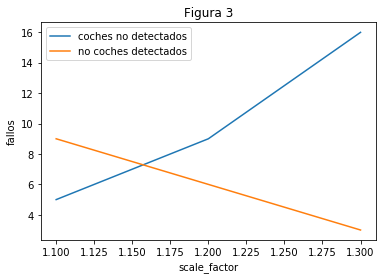

In [19]:
x = [1.1, 1.2, 1.3]
y1 = [5, 9, 16]
y2 = [9, 6, 3]

plt.plot(x,y1, label='coches no detectados')
plt.plot(x,y2, label='no coches detectados')
plt.title("Figura 3")
plt.xlabel("scale_factor")
plt.ylabel("fallos")
plt.legend()

Cuando el valor de la variable es bajo, detecta más objetos a diferentes escalas. Por ello, se deja menos coches
sin detectar (linea azul) pero también detecta otros objetos que confunde con coches (no coches detectados).
Con un valor alto, detecta
objetos con menor rango de escalas, por lo que se deja muchos coches sin detectar, pero a cambio no devuelve
falsos positivos.

Con la otra variable sucede algo parecido, como se observa a continuación.

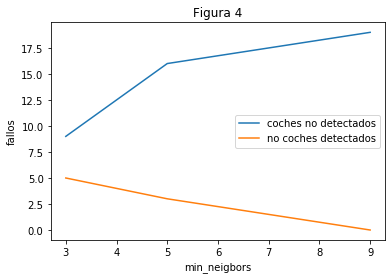

In [20]:
x = [3, 5, 9]
y1 = [9, 16, 19]
y2 = [5, 3, 0]

plt.plot(x,y1, label='coches no detectados')
plt.plot(x,y2, label='no coches detectados')
plt.title("Figura 4")
plt.xlabel("min_neigbors")
plt.ylabel("fallos")
plt.legend()

Cuanto mayor es el número de vecinos necesario para dar una zona por válida, más restringida es la detección y se
detectan menos coches, por lo que habrá más coches sin detectar y menos falsos positivos. Cuando el número es
pequeño, ocurre lo contrario.

Los valores que se han seleccionado finalmente son los presentes en el *main*.

# Detección del coche en secuencias de video

Este apartado aparece desarrollado en el fichero *deteccion_video.py*.

Se comienza importando las librerías necesarias. En este apartado se usará OpenCV y los ficheros creados en los
apartados anteriores, ya que este consiste en aplicar los anteriores a archivos de vídeo.

In [21]:
import cv2
import deteccion_orb as orbdet
import deteccion_haar as haardet

En este apartado se aplicarán las dos detecciones desarrolladas antes (haar y orb) sobre unas muestras de video. Ya que
son totalmente independientes, se pueden separar en métodos dintintos.

El método `haar_detection()` recibe el nombre del video a procesar, el cual debe estar en el mismo directorio, y el
factor de escala y número mínimo de vecinos que se pasarán al detector haar. Primero, se crean los clasificadores del
mismo modo que en el apartado anterior. A continuación, se invoca al constructor `cv2.VideoCapture()`, que recibe el nombre
del video y crea un objeto que permitirá la lectura de este. También se declaran unas listas que almacenarán los
frames en niveles de gris y color. En el bucle se obtiene cada frame del video mediante el método `read()`, que devuelve
un boolean indicando si se ha obtenido un frame y el frame en cuestión. Si el boolean tiene valor verdadero, se guarda
el frame en color y en niveles de gris. Se invoca el detector del apartado anterior `haardet.detect()` y se obtiene una
lista con los frames modificados con las zonas de interés marcadas. Se libera el objeto *VideoCapture* y se devuelve la
lista de frames.

In [ ]:
def haar_detection(video_source, scale_factor, min_neighbors):
    coches_cascade = cv2.CascadeClassifier('haar_opencv_4.1-4.2/coches.xml')
    matricula_cascade = cv2.CascadeClassifier('haar_opencv_4.1-4.2/matriculas.xml')

    cap = cv2.VideoCapture(video_source)

    gray_frames = []
    color_frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if ret == True:
            gray_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
            color_frames.append(frame)
        else:
            break

    frames = haardet.detect(gray_frames, color_frames, coches_cascade, matricula_cascade, scale_factor, min_neighbors)

    cap.release()
    return frames

El método `orb_detection()` recibe dos parámetros adicionales respecto al método implementado en el primer apartado. El
primero es el nombre del video a procesar y el segundo, el ratio de frames del video sobre el que se realiza la
detección. Un video de unos minutos puede tener miles de frames, lo cual ralentiza enormemente la detección, es por ello
que se indica el ratio de frames a detectar. Si el ratio es 10, se detectará 1 de cada 10 frames y el resultado
obtenido se dibujará en todos estos frames, es decir, se detectará en el primero y dejará una estela en los otros 9.
Se deben almacenar todos los frames del video sin procesar (*all_frames*), los frames a procesar en gris y color
(*gray_frames* y *color_frames*) y los frames procesados intercalados con el resto de frames (*output_frames*).
El bucle recorre los frames del video como en el método anterior y mediante la operación del módulo obtiene los frames a
procesar.

A continuación se cargan las imágenes de entrenamiento, se crea el detector ORB, se obtienen la tabla de puntos de
interés aprendidos y el flann entrenado y se llama al método `orbdet.detect()`, que devuelve una lista de frames
procesados con los centros de los frontales marcados. Para intercalar estos frames con los restantes, se declara una
variable _point_ cuyo valor se irá actualizando con el centro detectado en los frames. Este punto marcará la estela
a dibujar en
los frames no procesados. Los índices de las imágenes procesadas (0, 10, 20,...) entrarán por la primera rama del *if* y
se accederá a la tupla que contiene las coordenadas del centro señalado. Ya que las tuplas son inmutables, hay que
volcar el contenido a la variable _point_. Se dibuja un círculo en el punto obtenido en el frame correspondiente y se
guarda el frame en la lista a devolver. Para el resto de frames, se entra en la rama *else* y se dibuja un
círculo en el punto de estela. Para acabar, se libera el objeto de video y se devuelve la lista con todos los frames.

In [22]:
def orb_detection(video_source, frame_rate, num_keypoints, scale_factor, pyramid_levels, knn_matches,
                  gaussian_kernel_sigma, debug):
    cap = cv2.VideoCapture(video_source)

    all_frames = []
    color_frames = []
    gray_frames = []
    output_frames = []
    count = -1

    while cap.isOpened():
        count += 1
        ret, frame = cap.read()
        if ret == True:
            all_frames.append(frame)
            if count % frame_rate == 0:
                color_frames.append(frame)
                gray_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
        else:
            break

    train_images = orbdet.load()
    orb = cv2.ORB_create(nfeatures=num_keypoints, scaleFactor=scale_factor, nlevels=pyramid_levels)
    match_table, flann = orbdet.train(train_images, orb)
    detected_points = orbdet.detect(gray_frames, orb, match_table, flann, knn_matches, gaussian_kernel_sigma, debug)

    count = -1
    point = [0, 0]
    for i in range(len(all_frames)):
        count += 1
        if count % frame_rate == 0:
            t = detected_points[int(i / frame_rate)]
            point = [t[0], t[1]]
            cv2.circle(color_frames[int(i / frame_rate)], (point[0], point[1]), 5, (255, 0, 0), thickness=4,
                       lineType=8, shift=0)

            output_frames.append(color_frames[int(i / frame_rate)])
        else:
            cv2.circle(all_frames[i], (point[0], point[1]), 5, (255, 0, 0), thickness=4, lineType=8, shift=0)
            output_frames.append(all_frames[i])

    cap.release()
    return output_frames

El siguiente método `show()` recibe el nombre del video, la lista de frames y los frames por segundo del video. Del
nombre del video se extrae el título buscando la primera aparición del carácter punto mediante la
función `video_source.find('.')` y descartando la extensión. Se muestra el frame por pantalla y se realiza una espera
mediante la función `cv2.waitKey()`, que recibe un número que indica la espera a realizar.

In [23]:
def show(video_source, frames, fps):
    for frame in frames:
        cv2.imshow('output_' + video_source[:video_source.find('.')], frame)
        if cv2.waitKey(fps) & 0xFF == ord('q'):
            break

En la función principal se obtiene el número de frames por segundo del video mediante `cv2.VideoCapture().get()`. El
flag 5 sirve para obtener dicho dato. El número devuelto tiene decimales, se convierte a entero y se multiplica por 2
debido a que se ha comprobado que de este modo el video procesado mantiene su velocidad y duración. Se obtienen los
frames procesados del video mediante haar y orb y se muestran por pantalla.

In [24]:
def main(video_source, frame_rate, num_keypoints, scale_factor, pyramid_levels, knn_matches, gaussian_kernel_sigma,
         min_neighbors, debug=0):
    fps = int(cv2.VideoCapture(video_source).get(5)) * 2
    haar_frames = haar_detection(video_source, scale_factor, min_neighbors)
    orb_frames = orb_detection(video_source, frame_rate, num_keypoints, scale_factor, pyramid_levels, knn_matches,
                               gaussian_kernel_sigma, debug)
    show(video_source, haar_frames, fps)
    show(video_source, orb_frames, fps)

Como en el resto de apartados, se introduce una estructura de control para poder ejecutar el código al
ejecutar el mandato `python deteccion_video.py`. Se han declarado unas constantes que representan todas las variables
de las que depende el programa. Se procesará por defecto el _video2.wmv_ descargado del aula virtual.

In [25]:
if __name__ == "__main__":
    source = 'video2.wmv'
    NUM_KEYPOINTS = 100
    SCALE_FACTOR = 1.3
    PYRAMID_LEVELS = 4
    KNN_MATCHES = 6
    GAUSSIAN_KERNEL_SIGMA = 2
    FRAME_RATE = 10
    MIN_NEIGHBORS = 5

    main(source, FRAME_RATE, NUM_KEYPOINTS, SCALE_FACTOR, PYRAMID_LEVELS, KNN_MATCHES, GAUSSIAN_KERNEL_SIGMA,
         MIN_NEIGHBORS)

Al ejecutar el fichero en la terminal se lanzarán secuencialmente dos ventanas de video, una para cada tipo de
detección. Se observa que, para el video mencionado, la matrícula se encuentra siempre con la detección en imagen, 
mientras que la detección en coche no siempre la detecta, debido a que no siempre detecta el coche.

Debido a que se usan los métodos de los apartados anteriores y a que la obtención de estadísticas es mucho más 
complicada para video, no se ha realizado en este apartado.

